In [ ]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 9.6 MB/s eta 0:00:00


In [ ]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from catboost import CatBoostClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

In [ ]:
data = pd.read_csv('/content/synthetic_financial_data.csv')
data

,transaction_id,customer_id,merchant_id,amount,transaction_time,is_fraudulent,card_type,location,purchase_category,customer_age,transaction_description
0,1,1082,2027,5758.59,2023-01-01 00:00:00,0,MasterCard,City-30,Gas Station,43,Purchase at Merchant-2027
1,2,1015,2053,1901.56,2023-01-01 00:00:01,1,Visa,City-47,Online Shopping,61,Purchase at Merchant-2053
2,3,1004,2035,1248.86,2023-01-01 00:00:02,1,MasterCard,City-6,Gas Station,57,Purchase at Merchant-2035
3,4,1095,2037,7619.05,2023-01-01 00:00:03,1,Discover,City-6,Travel,59,Purchase at Merchant-2037
4,5,1036,2083,1890.10,2023-01-01 00:00:04,1,MasterCard,City-34,Retail,36,Purchase at Merchant-2083
...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,1056,2023,8935.28,2023-01-01 02:46:35,1,MasterCard,City-39,Restaurant,36,Purchase at Merchant-2023
9996,9997,1053,2026,30.15,2023-01-01 02:46:36,0,MasterCard,City-32,Retail,42,Purchase at Merchant-2026
9997,9998,1041,2034,6333.64,2023-01-01 02:46:37,0,American Express,City-1,Online Shopping,36,Purchase at Merchant-2034
9998,9999,1009,2019,2837.13,2023-01-01 02:46:38,1,Visa,City-11,Retail,57,Purchase at Merchant-2019


In [ ]:
data.describe()

,transaction_id,customer_id,merchant_id,amount,is_fraudulent,customer_age
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000
mean,5000.50000,1051.272300,2050.486600,4958.381617,0.506800,44.047500
std,2886.89568,28.864062,28.877801,2899.699675,0.499979,15.321707
min,1.00000,1001.000000,2001.000000,10.610000,0.000000,18.000000
25%,2500.75000,1026.000000,2025.000000,2438.175000,0.000000,31.000000
50%,5000.50000,1052.000000,2050.000000,4943.945000,1.000000,44.000000
75%,7500.25000,1076.000000,2076.000000,7499.312500,1.000000,57.000000
max,10000.00000,1100.000000,2100.000000,9999.750000,1.000000,70.000000


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   transaction_id           10000 non-null  int64  
 1   customer_id              10000 non-null  int64  
 2   merchant_id              10000 non-null  int64  
 3   amount                   10000 non-null  float64
 4   transaction_time         10000 non-null  object 
 5   is_fraudulent            10000 non-null  int64  
 6   card_type                10000 non-null  object 
 7   location                 10000 non-null  object 
 8   purchase_category        10000 non-null  object 
 9   customer_age             10000 non-null  int64  
 10  transaction_description  10000 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 859.5+ KB


In [ ]:
data.isnull().sum()

transaction_id             0
customer_id                0
merchant_id                0
amount                     0
transaction_time           0
is_fraudulent              0
card_type                  0
location                   0
purchase_category          0
customer_age               0
transaction_description    0
dtype: int64

# Exploratory Data Analysis

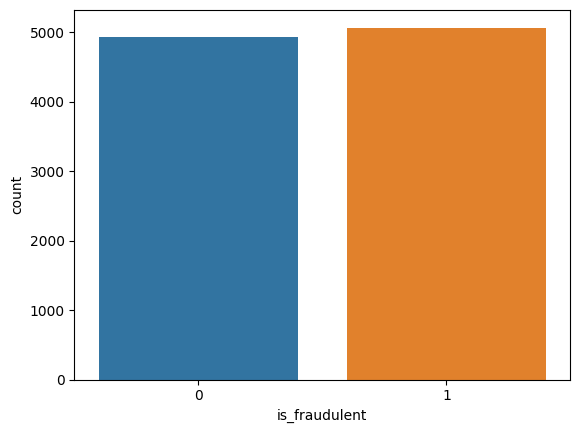

In [ ]:
sns.countplot(data=data,x='is_fraudulent')
plt.show()

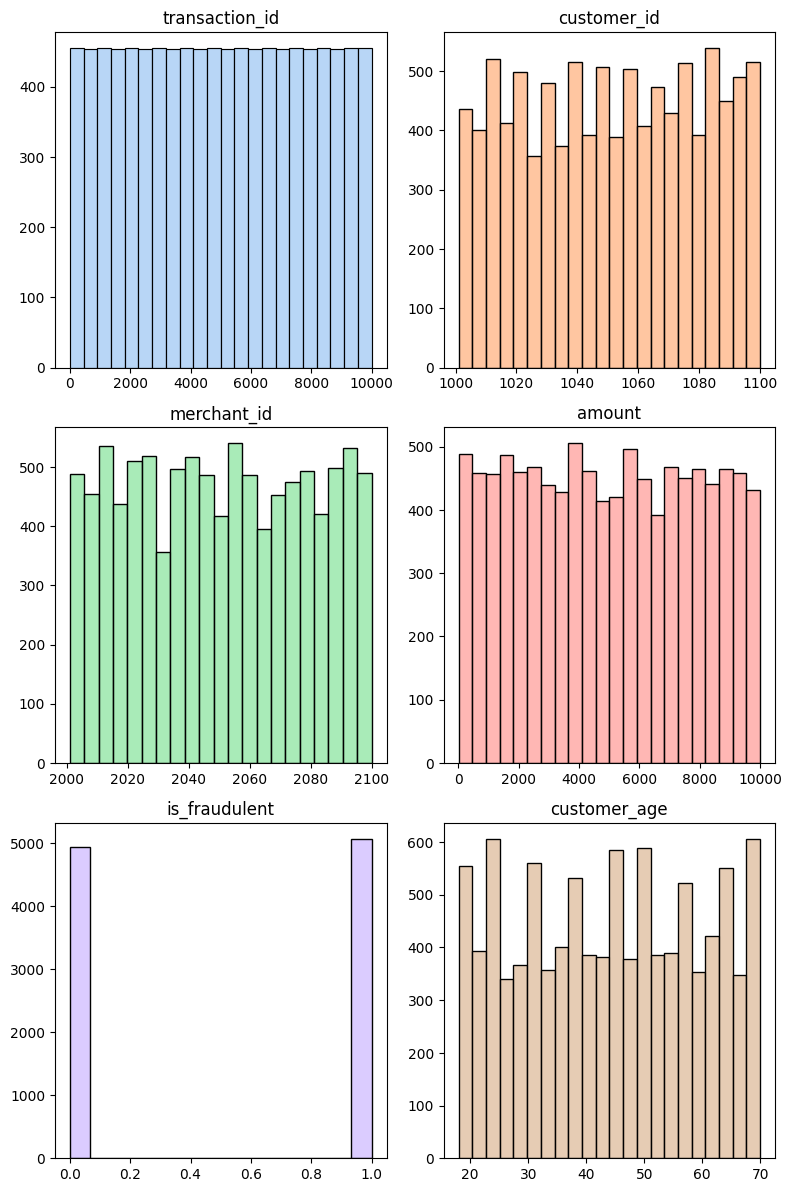

In [ ]:
numeric_columns = [col for col in data.columns if data[col].dtype in ['int64','float64']]

fig, axes = plt.subplots(3,2, figsize=(8,12))
colors = sns.color_palette('pastel', len(numeric_columns))

for col, ax, color in zip(numeric_columns, axes.flatten(), colors):
    sns.histplot(data[col], ax=ax, color=color)
    ax.set_ylabel('')
    ax.set_xlabel('')
    ax.set_title(col)
    ax.grid(False)
    fig.tight_layout(pad=1.0)

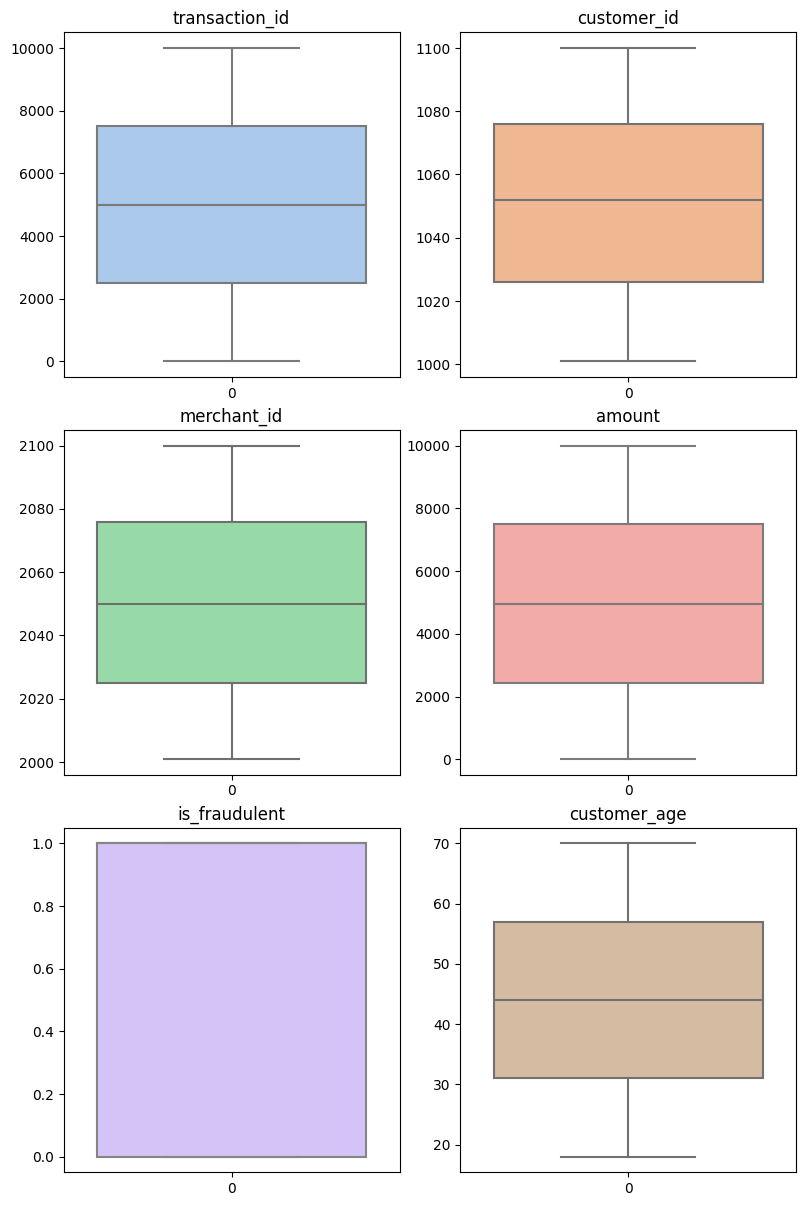

In [ ]:
## outlier detection
fig, axes = plt.subplots(3,2, figsize=(8,12))
colors = sns.color_palette('pastel', len(numeric_columns))

for col, ax, color in zip(numeric_columns, axes.flatten(), colors):
    sns.boxplot(data[col], ax=ax, color=color)
    ax.set_ylabel('')
    ax.set_title(col)
    ax.grid(False)
    fig.tight_layout(pad=0.5)

[Text(0.5, 1.0, 'The Correlation between Distribution and Amount of Card Types')]

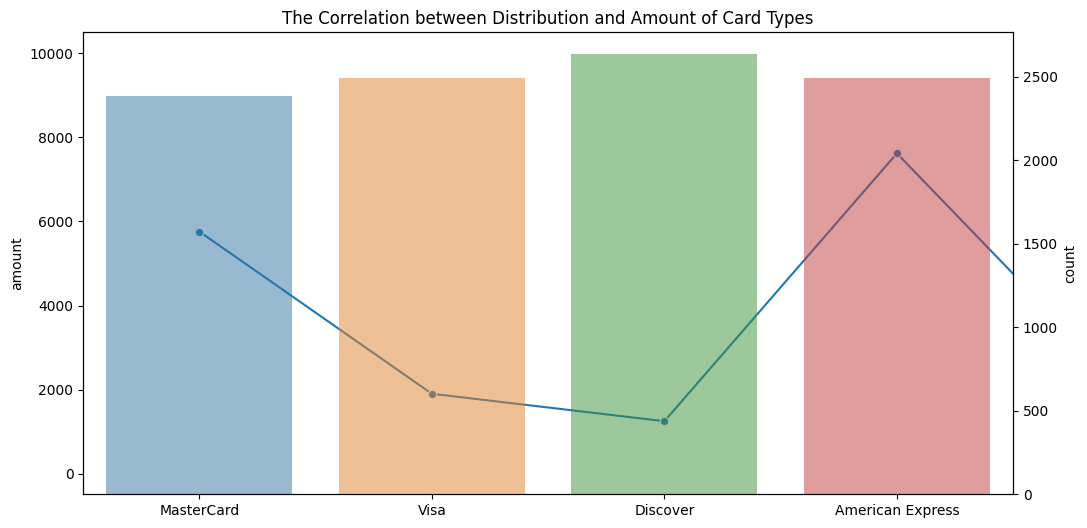

In [ ]:
from numpy.ma import count
matplotlib.rc_file_defaults()
ax1 = sns.set_style(style=None, rc=None )

fig, ax1 = plt.subplots(figsize=(12,6))

sns.lineplot(data = data['amount'], marker='o', sort = False, ax=ax1)
ax2 = ax1.twinx()

sns.countplot(data=data,x='card_type',alpha=0.5, ax=ax2).set(title='The Correlation between Distribution and Amount of Card Types')

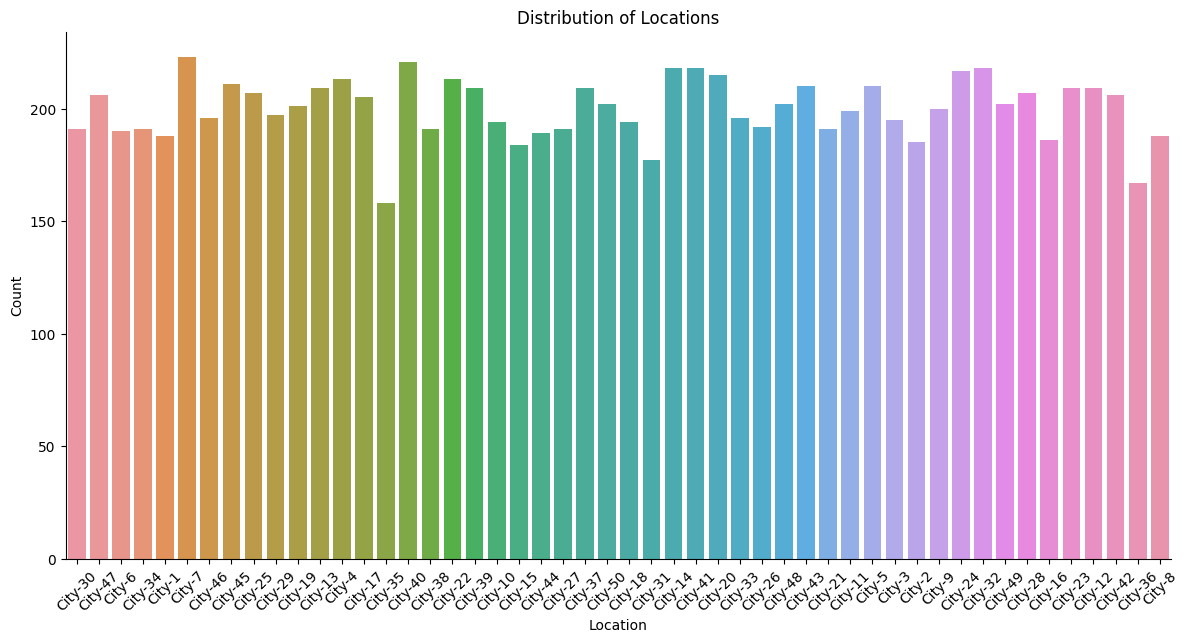

In [ ]:
# Categorical plot for 'location'
sns.catplot(data=data, x='location', kind='count', height=6, aspect=2)
plt.xlabel('Location')
plt.ylabel('Count')
plt.title('Distribution of Locations')
plt.xticks(rotation=45)
plt.show()

[Text(0.5, 1.0, 'The Correlation between Distribution and Amount of Categories Purchase')]

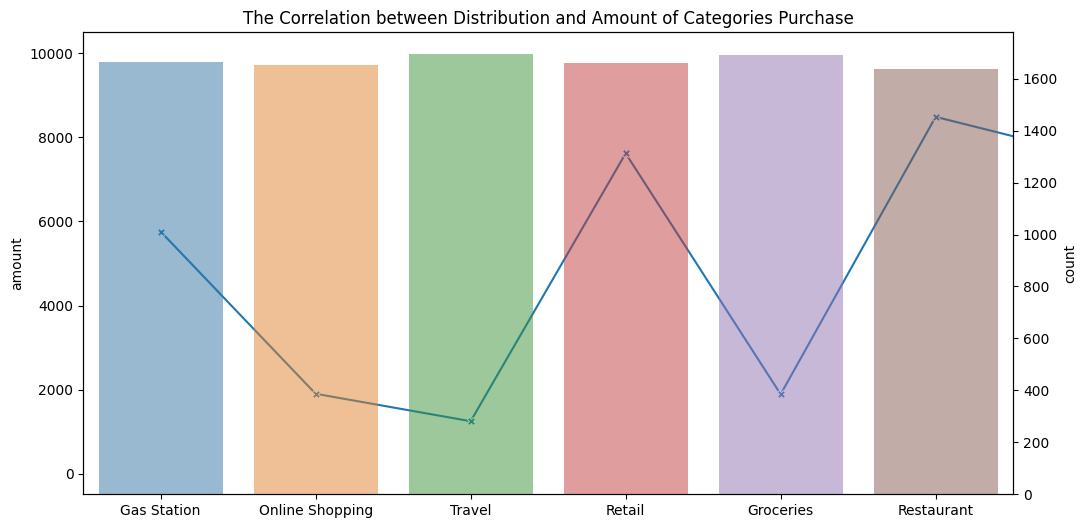

In [ ]:
# Categorical plot for 'purchase_category'
matplotlib.rc_file_defaults()
ax3 = sns.set_style(style=None, rc=None )

fig, ax3 = plt.subplots(figsize=(12,6))

sns.lineplot(data = data['amount'], marker='X', sort = False, ax=ax3)
ax4 = ax3.twinx()

sns.countplot(data=data,x='purchase_category',alpha=0.5, ax=ax4).set(title='The Correlation between Distribution and Amount of Categories Purchase')

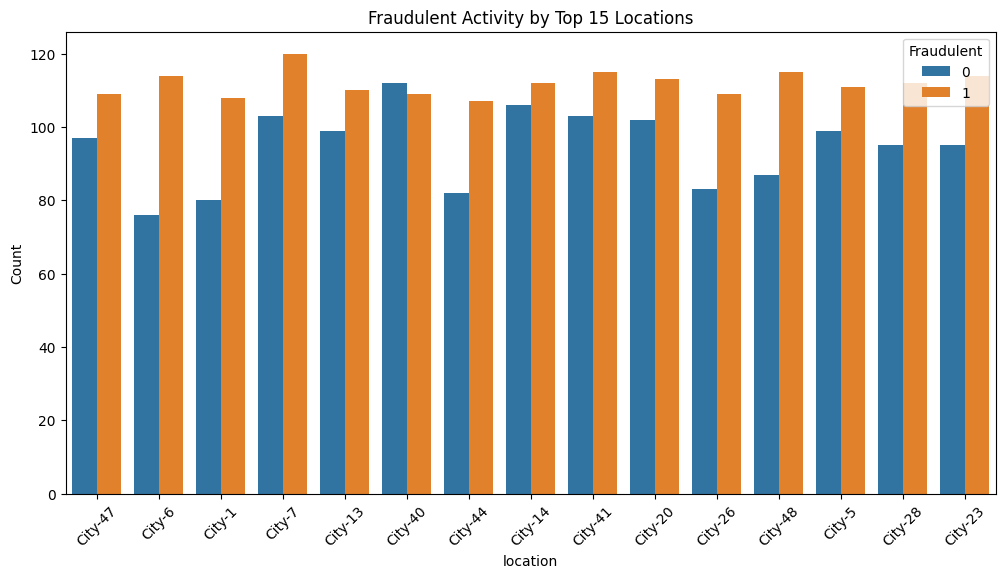

In [ ]:
top_15_locations = data[data['is_fraudulent'] == 1]['location'].value_counts().nlargest(15).index.sort_values(ascending=True)

plt.figure(figsize=(12, 6))
sns.countplot(data=data[data['location'].isin(top_15_locations)], x='location', hue='is_fraudulent')
plt.xlabel('location')
plt.ylabel('Count')
plt.title('Fraudulent Activity by Top 15 Locations')
plt.legend(title='Fraudulent', loc='upper right')
plt.xticks(rotation=45)
plt.show()

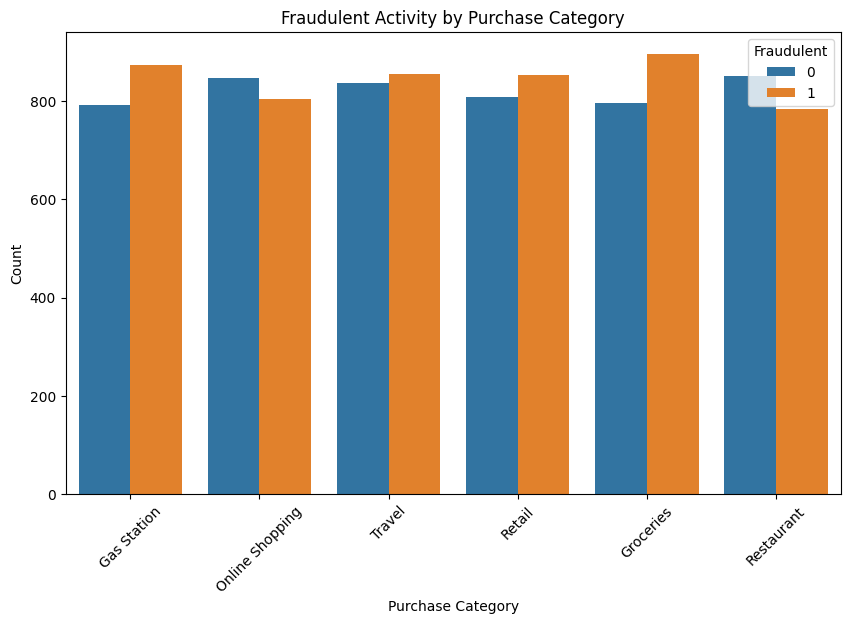

In [ ]:
plt.figure(figsize=(10, 6))
sns.countplot(data=data, x='purchase_category', hue='is_fraudulent')
plt.xlabel('Purchase Category')
plt.ylabel('Count')
plt.title('Fraudulent Activity by Purchase Category')
plt.legend(title='Fraudulent', loc='upper right')
plt.xticks(rotation=45)
plt.show()

In [ ]:
numerical_columns = ['amount','customer_age']
categorical_columns = ['transaction_time','card_type','location','purchase_category','transaction_description']

numerical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())
])

categorical_preprocessor = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ("numerical",numerical_preprocessor,numerical_columns),
        ("categorical",categorical_preprocessor,categorical_columns)
])

In [ ]:
X = data[numerical_columns+categorical_columns]
y = data.is_fraudulent

X_train,X_test,y_train,y_test = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=42)

X_train_encoded = preprocessor.fit_transform(X_train)
X_test_encoded = preprocessor.transform(X_test)

In [ ]:
cat = CatBoostClassifier(learning_rate=0.01145556456,
                         iterations=624,
                         depth=7,
                         l2_leaf_reg=0.01,
                         silent=True,
                         random_state=42)

cat.fit(X_train_encoded, y_train)
preds = cat.predict(X_test_encoded)
print(accuracy_score(y_test,preds))

0.5135


In [ ]:
print("Classification Report:\n", classification_report(y_test, preds))

Classification Report:
               precision    recall  f1-score   support

           0       0.50      0.48      0.49       966
           1       0.53      0.55      0.54      1034

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



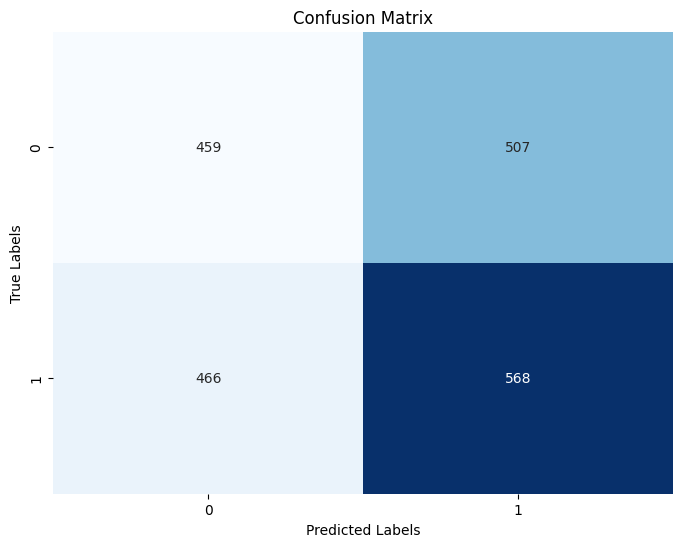

In [ ]:
cm = confusion_matrix(y_test, preds)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()